# Importing PlanetScope mosaics into xarray

**Author:** Robbi Bishop-Taylor, Geoscience Australia

---


This takes mosaiced PlanetScope layers (generated using `mosaic_planet.ipynb`) and uses Dask to import them as an xarray dataset.

In [1]:
import os
import sys
import glob
import pandas as pd
import xarray as xr


In [2]:
# !pip install --extra-index-url="https://packages.dea.ga.gov.au" git+https://github.com/GeoscienceAustralia/dea-notebooks.git#subdirectory=Tools

In [3]:
from dea_tools.plotting import xr_animation

## Lazily load PlanetScope data as an xarray dataset using Dask
Dask allows us to 'lazily' load the mosaiced rasters from file without actually loading them into memory. This is fast, and allows you to then actually import only a specific portion of the resulting xarray.

In [4]:
def time_index_from_filenames(filenames, string_slice=slice(0, 10)):
    '''
    Helper function to generate a Pandas datetimeindex object
    from dates contained in a file path string
    '''
    
    date_strings = [os.path.basename(i)[string_slice] for i in filenames]
    
    return pd.to_datetime(date_strings)

# Get file paths and obtain list of dates from file
mosaic_list = sorted(glob.glob('data/planetscope/mosaics/*_planetscope.tif'))

# Import data and create xarray dask array labelled by timestamps from files
time_var = xr.Variable('time', time_index_from_filenames(mosaic_list, string_slice=slice(0, 8)))
chunks = {'x': 1452, 'y': 1839, 'band': 1}
concat_arrays = xr.concat([xr.open_rasterio(i, chunks=chunks) for i in mosaic_list], dim=time_var)

# Convert to dataset and set band names
concat_ds = concat_arrays.to_dataset(dim='band')
concat_ds = concat_ds.rename({1: 'blue', 2: 'green', 3: 'red', 4: 'nir'})
concat_ds = concat_ds.sortby('time')
concat_ds


<xarray.Dataset>
Dimensions:  (time: 227, x: 1452, y: 1839)
Coordinates:
  * y        (y) float64 6.741e+06 6.741e+06 6.741e+06 ... 6.735e+06 6.735e+06
  * x        (x) float64 2.128e+05 2.128e+05 2.128e+05 ... 2.172e+05 2.172e+05
  * time     (time) datetime64[ns] 2017-03-11 2017-03-20 ... 2018-06-26
Data variables:
    blue     (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
    green    (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
    red      (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
    nir      (time, y, x) uint16 dask.array<chunksize=(1, 1839, 1452), meta=np.ndarray>
Attributes:
    transform:      (3.0, 0.0, 212838.0, 0.0, -3.0, 6740733.0)
    crs:            +init=epsg:32756
    res:            (3.0, 3.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

## Import data using Dask's compute
PlanetScope data is very large and memory intensive. For a quick example, here we use Dask to load only a 20 day sample of the data:

In [5]:
# Give a list of time indices to load
time_indices = range(0, 20)

# Load the data
planet_ds = concat_ds.isel(time=time_indices).compute()
planet_ds

<xarray.Dataset>
Dimensions:  (time: 20, x: 1452, y: 1839)
Coordinates:
  * y        (y) float64 6.741e+06 6.741e+06 6.741e+06 ... 6.735e+06 6.735e+06
  * x        (x) float64 2.128e+05 2.128e+05 2.128e+05 ... 2.172e+05 2.172e+05
  * time     (time) datetime64[ns] 2017-03-11 2017-03-20 ... 2017-06-06
Data variables:
    blue     (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    green    (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    red      (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    nir      (time, y, x) uint16 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
Attributes:
    transform:      (3.0, 0.0, 212838.0, 0.0, -3.0, 6740733.0)
    crs:            +init=epsg:32756
    res:            (3.0, 3.0)
    is_tiled:       0
    nodatavals:     (0.0, 0.0, 0.0, 0.0)
    scales:         (1.0, 1.0, 1.0, 1.0)
    offsets:        (0.0, 0.0, 0.0, 0.0)
    AREA_OR_POINT:  Area

## Animate layers

/g/data/v10/public/modules/dea-env/20200713/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


Exporting animation to animation.gif


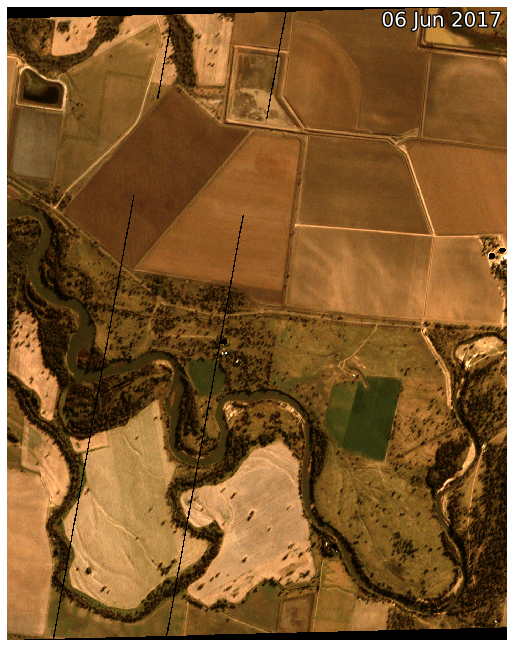

In [6]:
xr_animation(planet_ds, 
             bands=['red', 'green', 'blue'], 
             output_path='animation.gif')